In [1]:
#!/bin/python3
import numpy as np
import matplotlib.pyplot as plt

### Inputs, required arrays:

NUM_OF_PTCS = 32                                 #number of particles
NUM_OF_CELLS_BY_DIM_X = 8                        #number of particles
NUM_OF_CELLS_BY_DIM_Y = 8                        #number of particles
h = 1                                            #search radius (and cell size)

ptcs = np.arange(0, NUM_OF_PTCS, dtype=np.int32) #particle index
cptcs = np.zeros(NUM_OF_PTCS)                    #cell particle index (to which cell particle belongs)
xptcs = np.random.rand(NUM_OF_PTCS)*8            #particle x-coordinates
yptcs = np.random.rand(NUM_OF_PTCS)*8            #particle y-coordinates

In [2]:
### - Create GRID, generate cell index:
# Grid that covers particle domain is generated, for each cell is computed cell index based
# on cell coordinates. In the same way, cell index is computed for each particle (particles are
# assigned to cells).

# Here, the cell index is based on Morton Z-order curve with interval binary intervaling.

cidx = np.zeros((NUM_OF_CELLS_BY_DIM_X, NUM_OF_CELLS_BY_DIM_Y))

xbin = []; ybin = []
for i in range(NUM_OF_CELLS_BY_DIM_X):
    xbin.append(np.binary_repr(i, width=3))
for i in range(NUM_OF_CELLS_BY_DIM_Y):
    ybin.append(np.binary_repr(i, width=3))

for x in range(NUM_OF_CELLS_BY_DIM_X):
    for y in range(NUM_OF_CELLS_BY_DIM_Y):
        temp = np.concatenate(list(zip(ybin[y], xbin[x])))
        cidx[x,y] = int(str(int(''.join(temp))), 2)

        
# Computation of cell index for particles
for i in range(len(ptcs)):
    xb = np.binary_repr(int(np.floor(xptcs[i])), width=3)
    yb = np.binary_repr(int(np.floor(yptcs[i])), width=3)
    tempnp = np.concatenate(list(zip(xb, yb)))
    cptcsbin = int(''.join(tempnp))
    cptcs[i] = int(str(int(cptcsbin)), 2)

        
print("Map of cell indices in 2D:\n", np.rot90(cidx))
        
print("\nParticle index:\n", ptcs)
print("Particle cell index:\n", cptcs)

Map of cell indices in 2D:
 [[42. 43. 46. 47. 58. 59. 62. 63.]
 [40. 41. 44. 45. 56. 57. 60. 61.]
 [34. 35. 38. 39. 50. 51. 54. 55.]
 [32. 33. 36. 37. 48. 49. 52. 53.]
 [10. 11. 14. 15. 26. 27. 30. 31.]
 [ 8.  9. 12. 13. 24. 25. 28. 29.]
 [ 2.  3.  6.  7. 18. 19. 22. 23.]
 [ 0.  1.  4.  5. 16. 17. 20. 21.]]

Particle index:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Particle cell index:
 [28. 16. 10. 11. 45. 30. 16. 57.  3. 38. 28. 31. 22. 60. 55. 27. 40. 46.
 19. 16. 48. 62. 29. 34. 46. 38. 60. 18. 13. 32. 53. 47.]


In [3]:
# Then, the particles are sorted by its cell index, so they are stored in memory as the grid 
# indices goes.

cptcs_s, xptcs_s, yptcs_s = zip(*sorted(zip(cptcs, xptcs, yptcs)))
cptcs = np.array(cptcs_s,  dtype=np.int32 ); xptcs = np.array(xptcs_s); yptcs = np.array(yptcs_s)

print("Particle index (sorted):\n", ptcs)
print("particle cell index:\n", cptcs)

Particle index (sorted):
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
particle cell index:
 [ 3 10 11 13 16 16 16 18 19 22 27 28 28 29 30 31 32 34 38 38 40 45 46 46
 47 48 53 55 57 60 60 62]


In [4]:
### - Create COMPACT CELL LIST:
# Compat cell list is list that consist only of cells that contain any particles inside.
# For each non empty cell, ID of the first particle inside is stored. We can obtain number 
# of particles within given cell as difference between particle index of first particle and 
# particle index of first particle from following cell.

# MARKER - if is cell index of previous particle different of the actual one, 
# set marker to one.
marker = np.zeros(len(ptcs), dtype=np.int32)  
marker[0] = 1
for i in range(1, len(marker)):
    if cptcs[i] != cptcs[i-1]:
        marker[i] = 1
        
# SCAN - Prefix sum over the markers which determines indexing of the compact list array
# of non empty cells.
scan = np.zeros(len(ptcs), dtype=np.int32)            
scan = np.cumsum(marker)

print("Particle index:\n", ptcs)
print("Particle cell index:\n", cptcs)
print("Marker:\n", marker)
print("Scan:\n", scan)

# Create compact list composed by list indices of non empty cells in following way.
# For each non empty cell we store index of first particle contained inside this cell
cellCompactList_ptcsidx = np.zeros(scan[-1], dtype=np.int32)
cellCompactList_cellidx = np.zeros(scan[-1], dtype=np.int32)

cellCompactList_ptcsidx[0] = ptcs[0]; cellCompactList_cellidx[0] = cptcs[0]
for i in range(1, len(ptcs)):
    if cptcs[i] != cptcs[i-1]:
        cellCompactList_ptcsidx[scan[i]-1] = i
        cellCompactList_cellidx[scan[i]-1] = cptcs[i]


Particle index:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Particle cell index:
 [ 3 10 11 13 16 16 16 18 19 22 27 28 28 29 30 31 32 34 38 38 40 45 46 46
 47 48 53 55 57 60 60 62]
Marker:
 [1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1]
Scan:
 [ 1  2  3  4  5  5  5  6  7  8  9 10 10 11 12 13 14 15 16 16 17 18 19 19
 20 21 22 23 24 25 25 26]


In [5]:
#Results:
print("Partile index:\n", ptcs)
print("Partile cell index (i.e. in which cell particle is):\n", cptcs)

print("\nCOMPACT LIST:")
for i in range(len(cellCompactList_ptcsidx)):
    print("Cell idx: ",cellCompactList_cellidx[i], " containts first particle: ", cellCompactList_ptcsidx[i])

Partile index:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Partile cell index (i.e. in which cell particle is):
 [ 3 10 11 13 16 16 16 18 19 22 27 28 28 29 30 31 32 34 38 38 40 45 46 46
 47 48 53 55 57 60 60 62]

COMPACT LIST:
Cell idx:  3  containts first particle:  0
Cell idx:  10  containts first particle:  1
Cell idx:  11  containts first particle:  2
Cell idx:  13  containts first particle:  3
Cell idx:  16  containts first particle:  4
Cell idx:  18  containts first particle:  7
Cell idx:  19  containts first particle:  8
Cell idx:  22  containts first particle:  9
Cell idx:  27  containts first particle:  10
Cell idx:  28  containts first particle:  11
Cell idx:  29  containts first particle:  13
Cell idx:  30  containts first particle:  14
Cell idx:  31  containts first particle:  15
Cell idx:  32  containts first particle:  16
Cell idx:  34  containts first particle:  17
Cell idx:  38  containts first particle:  18
Cell i

In [6]:
### - FIND NEGIHBOURS:
# To find neighbours, we iterate over each cell in compact list. For each cell we determine its 
# neighbour cells But due to that we works with compact list containing only non empty cells, 
# I still need to figure out how to perform the search over neighbors cells.
   
# To see how the list works... 
for c in range(len(cellCompactList_cellidx)):
    try:
        nptcs = cellCompactList_ptcsidx[c+1] - cellCompactList_ptcsidx[c]
    except:
        nptcs = len(ptcs) - cellCompactList_ptcsidx[c]   
    print("Numer of particles in cell:", cellCompactList_cellidx[c], " is: ", nptcs)

# Function to determine distance between two particle
def dist(i, j):
    return ((xptcs[i] - xptcs[j])**2 + (yptcs[i] - yptcs[j])**2)**0.5  
 
# ???
for c in range(len(cellCompactList_cellidx)): 
    cComp = cellCompactList_cellidx[c]
    
        


Numer of particles in cell: 3  is:  1
Numer of particles in cell: 10  is:  1
Numer of particles in cell: 11  is:  1
Numer of particles in cell: 13  is:  1
Numer of particles in cell: 16  is:  3
Numer of particles in cell: 18  is:  1
Numer of particles in cell: 19  is:  1
Numer of particles in cell: 22  is:  1
Numer of particles in cell: 27  is:  1
Numer of particles in cell: 28  is:  2
Numer of particles in cell: 29  is:  1
Numer of particles in cell: 30  is:  1
Numer of particles in cell: 31  is:  1
Numer of particles in cell: 32  is:  1
Numer of particles in cell: 34  is:  1
Numer of particles in cell: 38  is:  2
Numer of particles in cell: 40  is:  1
Numer of particles in cell: 45  is:  1
Numer of particles in cell: 46  is:  2
Numer of particles in cell: 47  is:  1
Numer of particles in cell: 48  is:  1
Numer of particles in cell: 53  is:  1
Numer of particles in cell: 55  is:  1
Numer of particles in cell: 57  is:  1
Numer of particles in cell: 60  is:  2
Numer of particles in cell

In [7]:
### - Create FULL CELL LIST:
# In contrast to COMPACT CELL LIST, in FULL CELL LIST all cells are stored, even the empty ones.
# For each cell, reference to first and last particle contained inside is stored.(Could be also 
# possible to store first particle and the number of contained particles.)

NOC = NUM_OF_CELLS_BY_DIM_X*NUM_OF_CELLS_BY_DIM_Y # number of cells

cellFullList_ptcsidx_first = np.zeros(NOC)
cellFullList_ptcsidx_last = np.zeros(NOC)

# Go through all particles and test its cell index vs previous particle cell index. If differs, 
# add particle ID to cell List as first particle in cell on position corresponding to particle 
# cell index.The cell index is then tested against cell index of following particles. If differs, 
# particle index is assig as the last particle in cell in the same way.

for i in range(0, len(ptcs)-1):
    if cptcs[i] != cptcs[i-1]: #well,...  
        cellFullList_ptcsidx_first[cptcs[i]] = i+1
    if cptcs[i] != cptcs[i+1]:
        cellFullList_ptcsidx_last[cptcs[i]] = i+1

# resolve the last elemet 
if cptcs[len(ptcs)-1] != cptcs[len(ptcs)-2]:   
    cellFullList_ptcsidx_first[cptcs[len(ptcs)-1]] = len(ptcs)
cellFullList_ptcsidx_last[cptcs[len(ptcs)-1]] = len(ptcs)

### Results
print("Particle position in array:\n", ptcs)
print("Particle index:\n", ptcs + 1)
print("Particle cell index:\n", cptcs)
print("\nParticle cellFullList - first:\n", cellFullList_ptcsidx_first)
print("\nParticle cellFullList - last:\n", cellFullList_ptcsidx_last)

# Obtain number of particles in given cell
print("\nFULL LIST:")
for i in range(NOC):
    if cellFullList_ptcsidx_first[i] == 0: continue #used to print onlyt nonempty cells
    print("Cell idx: ", i, " containts first particle: ", cellFullList_ptcsidx_first[i], \
          " and last particle: ", cellFullList_ptcsidx_last[i], " i. e. ", \
          cellFullList_ptcsidx_last[i] - cellFullList_ptcsidx_first[i] + 1, \
          " particles.")

# NOTE: Particles indexing starts with one, because we need to place zero to empty cell, to be able 
# to determine them as empty. Could NULL pointer solve this?

Particle position in array:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Particle index:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Particle cell index:
 [ 3 10 11 13 16 16 16 18 19 22 27 28 28 29 30 31 32 34 38 38 40 45 46 46
 47 48 53 55 57 60 60 62]

Particle cellFullList - first:
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  2.  3.  0.  4.  0.  0.  5.  0.
  8.  9.  0.  0. 10.  0.  0.  0.  0. 11. 12. 14. 15. 16. 17.  0. 18.  0.
  0.  0. 19.  0. 21.  0.  0.  0.  0. 22. 23. 25. 26.  0.  0.  0.  0. 27.
  0. 28.  0. 29.  0.  0. 30.  0. 32.  0.]

Particle cellFullList - last:
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  2.  3.  0.  4.  0.  0.  7.  0.
  8.  9.  0.  0. 10.  0.  0.  0.  0. 11. 13. 14. 15. 16. 17.  0. 18.  0.
  0.  0. 20.  0. 21.  0.  0.  0.  0. 22. 24. 25. 26.  0.  0.  0.  0. 27.
  0. 28.  0. 29.  0.  0. 31.  0. 32.  0.]

FULL LIST:
Cell idx:  3  containts first partic

In [8]:
### - FIND NEGIHBOURS:
# To find neighbours, we iterate over each cell. For each cell we determine its neighbour cell 
# in which we search for neighbour particles. We iterate over all neighbour cells, in every neighbour 
# cell we iterate over all particles and for each of these particles we run cycle over all particles 
# in the central (mother) cell and compare its distance to determine if these two particles are neighbours.

# For simplicity and visualization, the neighbor list is represented as a matrix.
neighbourList = np.zeros((len(ptcs), len(ptcs)))

# Function to determine neighbour cells in grid
X = NUM_OF_CELLS_BY_DIM_X-1; Y = NUM_OF_CELLS_BY_DIM_Y-1
neighbors = lambda x, y : [(x2, y2) for x2 in range(x-1, x+2) for y2 in range(y-1, y+2)
                           if (-1 < x <= X and -1 < y <= Y  and (0 <= x2 <= X) and (0 <= y2 <= Y))]

# loop over all cells in cellCompactList
for x in range(NUM_OF_CELLS_BY_DIM_X):
    for y in range(NUM_OF_CELLS_BY_DIM_Y): 
        c = int(cidx[x, y])
        if cellFullList_ptcsidx_first[c] == 0: continue
            
        """print("\nProcessing cell c: ", c)
        print("Numer of particles in cell:", c, " is: ", nptcs)"""
       
        # The simplies way is to look into all neighbor cells: (although this part needs to be improved)
        # Could be improved with ranges. Moreover, check if the neighbor cell is empty or not. 
        # If is empty, remove it from neighbour list. I think is better to do the check here then below, 
        # in loaded neighbour cell.
        
        nbscell = [int(cidx[i]) for i in (neighbors(x, y))
                   if cellFullList_ptcsidx_first[int(cidx[i])] != 0]
        
        """print("Neighbour cells to the current one:\n", nbscell)"""
    
        for nbc in nbscell:
        
            """print("Nbc: ", nbc)"""
        
            for nbp in range(int(cellFullList_ptcsidx_first[nbc]-1), int(cellFullList_ptcsidx_last[nbc])):
                for p in range(int(cellFullList_ptcsidx_first[c]-1), int(cellFullList_ptcsidx_last[c])):
                    if p == nbp: continue
                    if dist(p, nbp) < h:
                        neighbourList[p, nbp] += 1 

# NOTE+TODO: Unfortunately, we deal with empty cells, moreover, the cell index can be out of range 
# (ranges could help here).

Particle id:  1  has nbs:  [16]
Particle id:  4  has nbs:  [5, 6]
Particle id:  5  has nbs:  [4, 6]
Particle id:  6  has nbs:  [4, 5]
Particle id:  8  has nbs:  [9]
Particle id:  9  has nbs:  [8, 11]
Particle id:  10  has nbs:  [14]
Particle id:  11  has nbs:  [9, 12, 15]
Particle id:  12  has nbs:  [11, 14, 15]
Particle id:  13  has nbs:  [15]
Particle id:  14  has nbs:  [10, 12]
Particle id:  15  has nbs:  [11, 12, 13]
Particle id:  16  has nbs:  [1]
Particle id:  18  has nbs:  [19]
Particle id:  19  has nbs:  [18]
Particle id:  22  has nbs:  [23, 24]
Particle id:  23  has nbs:  [22, 24]
Particle id:  24  has nbs:  [22, 23]
Particle id:  27  has nbs:  [29]
Particle id:  28  has nbs:  [29, 30]
Particle id:  29  has nbs:  [27, 28, 30]
Particle id:  30  has nbs:  [28, 29, 31]
Particle id:  31  has nbs:  [30]


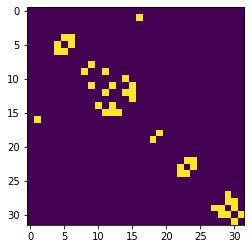

In [9]:
### Show the negihbour list

plt.imshow(neighbourList)
np.set_printoptions(threshold=np.inf)

def printNeighbourList(nbList):
    for x in range(len(ptcs)):
        x_nbsCount = 0;
        x_nbs = [];
        for y in range(len(ptcs)):
            if nbList[x,y] != 0:
                x_nbsCount += 1;
                x_nbs.append(y)
        
        if x_nbsCount != 0:
            print("Particle id: ", x ," has nbs: ", x_nbs)

printNeighbourList(neighbourList)

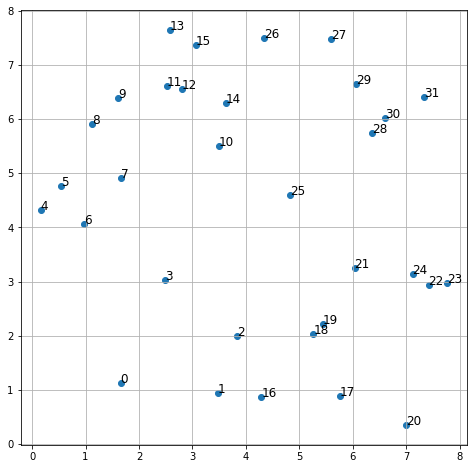

In [10]:
### Visualise the particle and grid

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(xptcs, yptcs)
plt.xlim = (0,8); plt.ylim = (0,12)
plt.grid()

for i, txt in enumerate(ptcs):
    ax.annotate(txt, (xptcs[i], yptcs[i]), fontsize=12)